In [ ]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

In [3]:
%matplotlib inline

## Packages

In [4]:
import numpy as np
import scipy as scipy
import scipy.stats as stats
import scipy.linalg as linalg
from pprint import pprint

import matplotlib.gridspec as gridspec
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import sys
import os
import copy
import string
import glob
import xarray as xr 

import warnings

## Modules

In [5]:
from custom_functions import *
from example_funcs import Stommel

# 1 parameter conditinuation

In [6]:
# Define initial parameters
F = 0
alpha = 100
mu = np.sqrt(6.2)

p=np.array([F,alpha,mu])

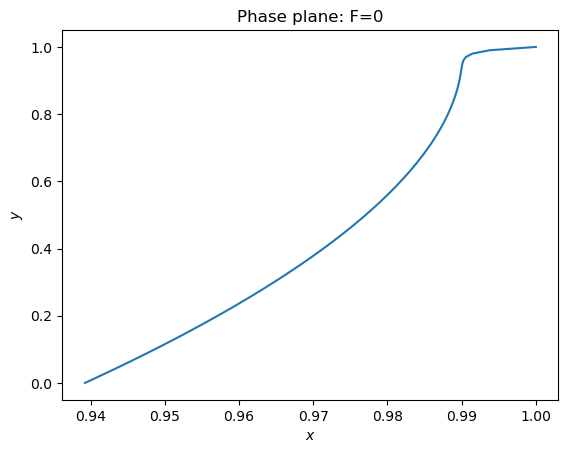

In [7]:
# Find equilibrium
x1 = 1
x2 = 1

# Set up for initial value problem solver
x0 = np.array([x1,x2])
tspan = [0,100]
h = 0.01

# Solve the ODE
[X,t,xeq1] = MyIVP(lambda t,x:Stommel(t,x,p),x0,tspan,h);

X = np.squeeze(X)
xeq1 = np.squeeze(xeq1)

plt.plot(X[0,:],X[1,:])
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Phase plane: F=0")

plt.show()

In [8]:
# Define RHS for tracking equilibria
RHS = lambda y: Stommel(0,y[0:2,:],np.array([y[2,:],alpha,mu]))

h=1e-6
df= lambda y: np.squeeze(MyJacobian(RHS,y,h),axis=2)

# Define MyTrackCurve initial points
y0 = np.append(xeq1,np.array([F]),axis=0);
ytan0 = np.expand_dims(np.array([0,0,1]),axis=1); # guess in the direction of increasing F

# Solve for the true initial tangent
df0 = df(y0)
zeros0 = np.zeros((2,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist1 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.005);

# guess in direction for decreasing F
ytan0 = np.expand_dims(np.array([0,0,-1]),axis=1);

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

ylist2 = MyTrackCurve(RHS,df,y0,ytan,nmax=1000,stepsize=0.005);


C:\Users\quinncr\AppData\Local\Temp\ipykernel_35072\1694514796.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS = lambda y: Stommel(0,y[0:2,:],np.array([y[2,:],alpha,mu]))


### Plot tracked curve

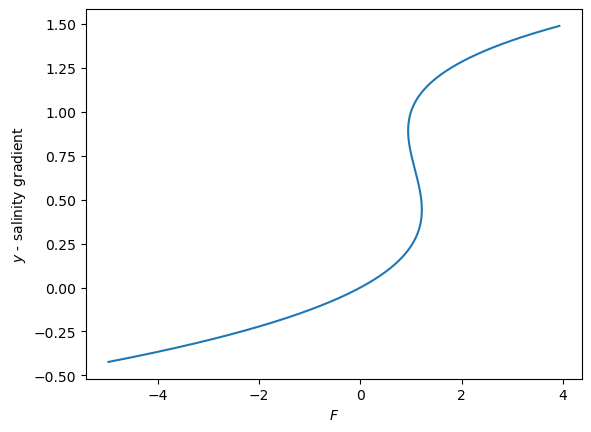

In [9]:
ylist = np.concatenate((np.flip(ylist2,1),ylist1),axis=1);

plt.plot(ylist[2,:],ylist[1,:])
plt.xlabel("$F$")
plt.ylabel("$y$ - salinity gradient")

plt.show()

### Plot as bifurcation diagram

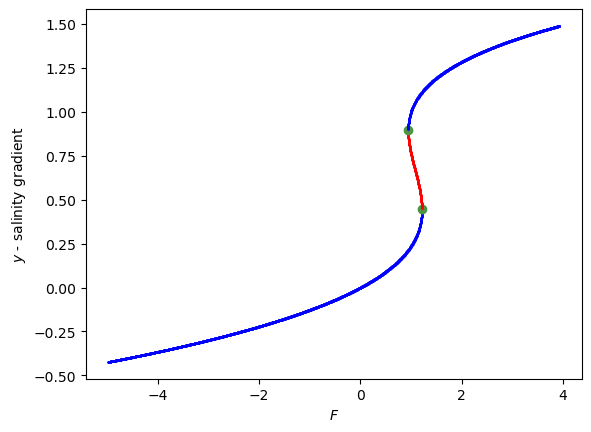

In [10]:
# empty vector for stability
stab = np.empty((ylist.shape[1],1))*np.nan

for i in np.arange(0,ylist.shape[1]):
    pi =np.array([ylist[2,i],alpha,mu])
    J = MyJacobian(lambda x:Stommel(0,x,pi),ylist[0:2,i],h)
    max_eig = max(np.real(linalg.eig(J[:,:,0])[0]))
    stab[i] = max_eig > 0
    if (i>0 and stab[i] != stab[i-1] and stab[i-1] != 10):
        #print(max_eig)
        stab[i] = 10

# define dark green color for Saddle-Node bifurcation marker
dg = (77./255, 149./255, 66./255)


for i in np.arange(0,ylist.shape[1]):
    if stab[i] == False:
        plt.plot(ylist[2,i],ylist[1,i],'b.',markersize=2,label = 'stable eq')
    elif stab[i] == True:
        plt.plot(ylist[2,i],ylist[1,i],'r.',markersize=2,label = 'unstable eq')
    elif stab[i] == 10:
        plt.plot(ylist[2,i],ylist[1,i],marker='o',color=dg,markersize=6,label='SN')
    else:
        print('Error - undefined stability type')

plt.xlabel("$F$")
plt.ylabel("$y$ - salinity gradient")
#plt.legend(loc ="upper left")
plt.show()

# 2 parameter conditinuation

In [11]:
def df_2param(y):
    J = MyJacobian(lambda x:Stommel(0,x,np.array([y[2],y[3],mu])),y[0:2],h)
    J = np.squeeze(J,axis=2)
    return J

RHS_fold = lambda y: np.append(Stommel(0,y[0:2,:],np.array([y[2,:],y[3,:],mu])),
                               np.expand_dims(np.array([linalg.det(df_2param(y))]),axis=1),axis=0)

df_fold= lambda y: np.squeeze(MyJacobian(RHS_fold,y,h),axis=2)

# Define MyTrackCurve initial points
f_inds = np.where(stab == 10)[0]
y0 = np.append(ylist[:,f_inds[0]],np.array([alpha]),axis=0)
ytan0 = np.expand_dims(np.array([0,0,0,1]),axis=1) # guess i the direction of increasing params

# Solve for the true initial tangent
df0 = np.squeeze(df_fold(y0))
zeros0 = np.zeros((3,))
zeros1 = np.append(zeros0,np.array([1.]),axis=0)
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yfold1 = MyTrackCurve(RHS_fold,df_fold,y0,ytan,stepsize=1,nmax=200);

# guess in direction for decreasing params
ytan0 = np.expand_dims(np.array([0,0,0,-1]),axis=1)

# Solve for the true initial tangent
f0 = np.concatenate((df0,np.transpose(ytan0)),axis=0)
z = np.linalg.lstsq(f0,zeros1,rcond=None)[0]
mult = np.sign(np.matmul(np.transpose(z),ytan0))
ytan = np.divide(z,linalg.norm(z))*mult

yfold2 = MyTrackCurve(RHS_fold,df_fold,y0,ytan,stepsize=1,nmax=200);

C:\Users\quinncr\AppData\Local\Temp\ipykernel_35072\985926087.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RHS_fold = lambda y: np.append(Stommel(0,y[0:2,:],np.array([y[2,:],y[3,:],mu])),
C:\Users\quinncr\AppData\Local\Temp\ipykernel_35072\985926087.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  J = MyJacobian(lambda x:Stommel(0,x,np.array([y[2],y[3],mu])),y[0:2],h)


## Plot as bifurcation diagram

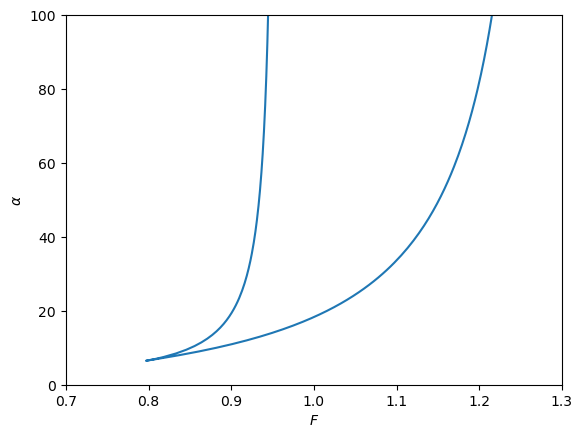

In [14]:
yfold = np.concatenate((np.flip(yfold2,1),yfold1),axis=1);

plt.plot(yfold[2,:],yfold[3,:])
plt.xlabel("$F$")
plt.ylabel("$\\alpha$")
plt.axis([0.7,1.3,0,100])

plt.show()

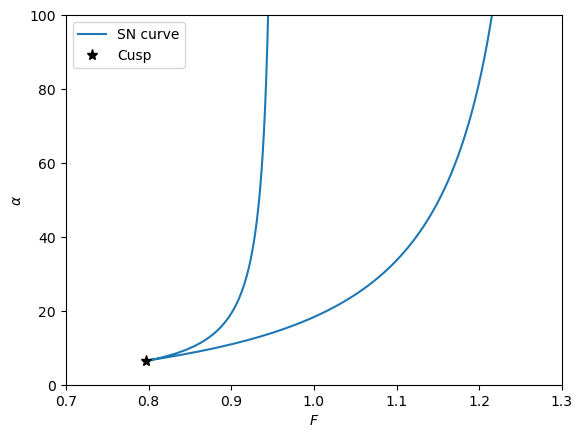

In [19]:
# add cusp point
plt.plot(yfold[2,:],yfold[3,:])
plt.plot(0.797,6.481,'*',color='k',markersize=8)
plt.xlabel("$F$")
plt.ylabel("$\\alpha$")
plt.axis([0.7,1.3,0,100])
plt.legend(['SN curve','Cusp'])

plt.show()